# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.


Признаки:

- DateCrawled — дата скачивания анкеты из базы
*VehicleType — тип автомобильного кузова
*RegistrationYear — год регистрации автомобиля
*Gearbox — тип коробки передач
*Power — мощность (л. с.)
*Model — модель автомобиля
*Kilometer — пробег (км)
*RegistrationMonth — месяц регистрации автомобиля
*FuelType — тип топлива
*Brand — марка автомобиля
*NotRepaired — была машина в ремонте или нет
*DateCreated — дата создания анкеты
*NumberOfPictures — количество фотографий автомобиля
*PostalCode — почтовый индекс владельца анкеты (пользователя)
*LastSeen — дата последней активности пользователя
*Целевой признак:
*Price — цена (евро)


План работы:
* Загрузить данные и провести предобработку.
*Выполнить сравнение моделей с использованием различных наборов гиперпараметров.
*Выбрать лучшую модель по результатам метрики RMSE и времени обучения.

## Подготовка данных

In [2]:
!pip install catboost
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score


In [4]:
try:
    data = pd.read_csv('/autos.csv')
except:
    data = pd.read_csv('autos.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.VehicleType.fillna('other', inplace=True)

VehicleType восстановить не представляется ,nan отнесем к прочим 

ниже отнести некуда, сделаем unkn и остальные

In [7]:
data.Gearbox.fillna('unkn', inplace=True)
data.Model.fillna('unkn', inplace=True)
data.FuelType.fillna('unkn', inplace=True)
data.Repaired .fillna('unkn', inplace=True)

In [8]:
data.loc[data['NumberOfPictures'] > 0, 'NumberOfPictures'].count()

0

Тут мы видим, что все строки с NumberOfPictures не больше  0, смысла в этой колонке нету. Удаляем

Тоже удаляем ибо пользы никакой, данные об анкете, ну и месяц регистрации авто, думаю месяц особо то не влияет 

In [9]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'DateCreated',
                 'LastSeen', 'RegistrationMonth', 'DateCrawled'], axis=1)

In [10]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [11]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [12]:
data = data.loc[(data['RegistrationYear'] <= 2016) &
                (data['RegistrationYear'] >= 1900)]

In [13]:
data.loc[data['Price'] >= 18000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unkn,125000,gasoline,audi,yes
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
204,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no
282,18700,coupe,2009,auto,213,mustang,80000,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...
353686,18429,sedan,2010,manual,272,3er,125000,petrol,bmw,no
353927,18500,sedan,2009,auto,190,unkn,150000,gasoline,audi,no
354045,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
354178,19990,small,2014,auto,185,a1,10000,petrol,audi,no


Text(0, 0.5, 'кол-во')

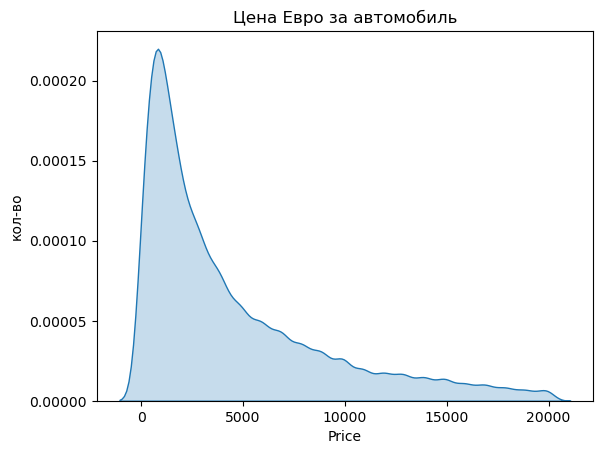

In [14]:
sns.kdeplot(data=data['Price'], shade=True, label='data_train')
plt.title('Цена Евро за автомобиль')
plt.ylabel('кол-во')

явно ошибка  в данных, уберём

In [15]:
data.loc[data['Price'] < 300]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
32,245,sedan,1994,unkn,0,golf,150000,petrol,volkswagen,no
40,0,other,1990,unkn,0,corsa,150000,petrol,opel,unkn
59,1,suv,1994,manual,286,unkn,150000,unkn,sonstige_autos,unkn
60,200,coupe,1995,manual,102,3er,150000,petrol,bmw,unkn
...,...,...,...,...,...,...,...,...,...,...
354273,150,small,1993,manual,55,astra,150000,petrol,opel,yes
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes
354338,180,other,1995,unkn,0,unkn,125000,petrol,opel,unkn


In [16]:
data = data[(data['Price'] > 400) &
            (data['Price'] <= 18000)]

In [17]:
data['Price'].describe()

count    303935.000000
mean       4680.615428
std        4212.689597
min         408.000000
25%        1450.000000
50%        3100.000000
75%        6800.000000
max       18000.000000
Name: Price, dtype: float64

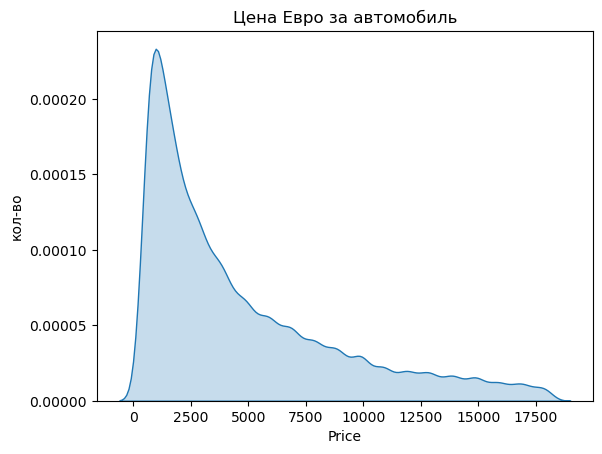

In [18]:
sns.kdeplot(data=data['Price'], shade=True)
plt.title('Цена Евро за автомобиль')
plt.ylabel('кол-во');

тут тоже явно проблема,  цена 0, уберём

In [19]:
power_norm = data.loc[(data['Power'] < 1000) &
                      (data['Power'] > 30), 'Power'].mean()

In [20]:
data['Power'].describe()

count    303935.000000
mean        114.339388
std         187.378134
min           0.000000
25%          75.000000
50%         106.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [21]:
data['Power'] = data['Power'].replace(0, power_norm)

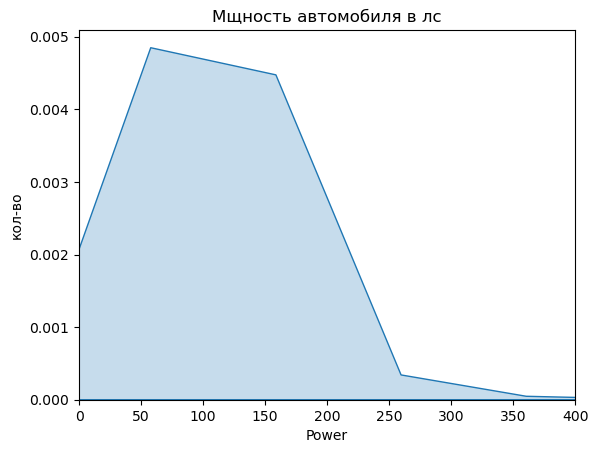

In [22]:
sns.kdeplot(data=data['Power'], shade=True)
plt.xlim(0, 400)
plt.title('Мщность автомобиля в лс')
plt.ylabel('кол-во')
plt.show()

In [23]:
data.loc[data['Power']<1]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [24]:
data.loc[(data['Power'] > 1000), 'Power']

1816      1398.0
5328      1001.0
7661      7515.0
7720      1400.0
9664      1779.0
           ...  
348137    9012.0
348237    2007.0
348668    2598.0
348883    1548.0
351947    1001.0
Name: Power, Length: 234, dtype: float64

In [25]:
data.loc[(data['Power'] > 1000) | (data['Power'] < 30), 'Power'] = power_norm

больше 1000 убрать, и взять среднею от 30 до 1000

In [26]:
data.duplicated().sum()

40106

In [27]:
data = data.drop_duplicates().reset_index(drop=True)

Итого в 1 разделе мы сделали предобработку данных, получили таблицу без пропусков, убрали лишнии столбцы, удалили дубликаты



## Обучение моделей

In [28]:
data_d = pd.get_dummies(data, drop_first=True)

Категории перевели в цифры

In [29]:
target_d = data_d['Price']
features_d = data_d.drop('Price', axis=1)
features_train_d, features_test_d, target_train_d, target_test_d = train_test_split(
    features_d, target_d, test_size=0.25, random_state=12345)

Разделим выборку

In [30]:
numeric = list(features_d)

In [31]:
numeric2 = ['RegistrationYear', 'Power', 'Kilometer']

In [32]:
scaler = StandardScaler()
scaler.fit(features_train_d[numeric2])
features_train_d[numeric2] = scaler.transform(features_train_d[numeric2])
features_test_d[numeric2] = scaler.transform(features_test_d[numeric2])

в одном из проектов Ревьювер советовал скалером проходить для лушчего результат. Разницы я тогда особой не заметил, но раз советовали значит будем использовать. но я понимаю зачем, должно улучшиться качество в теории.

Линейная регрессия


In [33]:
model = LinearRegression()
model.fit(features_train_d, target_train_d)
predictions_train_d = model.predict(features_train_d)
mse = mean_squared_error(target_train_d, predictions_train_d)
rmse = mse ** 0.5
print(rmse)

2569.4785013598157


И тут я решил пришло время понять, что такое Катбуст. И видимо зря, надо было просты модельки делать. Просидев более суток над катбустом, перечитав огромное кол-во статей, примеров решений и много- много - много чего. я кое- как из кусков разных примеров и переборов параметров составил, то что ниже.

In [34]:
target = data['Price']
features = data.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [35]:
scaler = StandardScaler()
scaler.fit(features_train[numeric2])
features_train[numeric2] = scaler.transform(features_train[numeric2])
features_test[numeric2] = scaler.transform(features_test[numeric2])

возвращаем котегории ибо катбуст умный он понимает.

In [36]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [37]:
catboost = CatBoostRegressor(loss_function='RMSE', random_state=12345)
parameters_cat = {'depth': [8, 10],
                  'learning_rate': np.arange(0.1, 1, 0.2),
                  'iterations': [100, 200, 300]}
catboost_grid = catboost.grid_search(parameters_cat,
                                     Pool(features_train, target_train,
                                          cat_features=categorical),
                                     cv=3,
                                     plot=False)

0:	learn: 5862.1667639	test: 5833.6276522	best: 5833.6276522 (0)	total: 213ms	remaining: 21.1s
1:	learn: 5386.3959910	test: 5360.8162207	best: 5360.8162207 (1)	total: 284ms	remaining: 13.9s
2:	learn: 4964.0664194	test: 4940.9341013	best: 4940.9341013 (2)	total: 362ms	remaining: 11.7s
3:	learn: 4586.4910700	test: 4566.2433758	best: 4566.2433758 (3)	total: 419ms	remaining: 10.1s
4:	learn: 4255.9180258	test: 4239.1571266	best: 4239.1571266 (4)	total: 480ms	remaining: 9.11s
5:	learn: 3961.1817132	test: 3945.8771196	best: 3945.8771196 (5)	total: 543ms	remaining: 8.51s
6:	learn: 3700.9507441	test: 3687.3665437	best: 3687.3665437 (6)	total: 605ms	remaining: 8.04s
7:	learn: 3474.5165226	test: 3462.5275922	best: 3462.5275922 (7)	total: 669ms	remaining: 7.69s
8:	learn: 3268.7597846	test: 3257.9934304	best: 3257.9934304 (8)	total: 741ms	remaining: 7.49s
9:	learn: 3092.2400607	test: 3081.9999397	best: 3081.9999397 (9)	total: 805ms	remaining: 7.25s
10:	learn: 2937.4802924	test: 2928.6841494	best: 2

In [38]:
catboost_grid['params']

{'depth': 10, 'iterations': 300, 'learning_rate': 0.30000000000000004}

In [39]:
df = pd.DataFrame(catboost_grid['cv_results'])
print('средняя катбуста RMSE = ',df['train-RMSE-mean'].mean())
print('минимальная катбуста RMSE = ',df['train-RMSE-mean'].min())

средняя катбуста RMSE =  1458.0599083870175
минимальная катбуста RMSE =  1295.711444393529


это лучшие параметры, внизу буду обучать модель 

Приступаем к LightGBM

Перебираем параметры

In [40]:
grid = {'n_estimators': [100, 200, 300], 'num_leaves': [
    31, 100, 200], 'learning_rate': [0.1, 0.3, 0.5]}

In [41]:
features_train[categorical] = features_train[categorical].astype('category')

In [42]:
model = lgb.LGBMRegressor(random_state=12345)

lgb_model = GridSearchCV(estimator=model,
                         param_grid=grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=3)

lgb_model.fit(features_train, target_train)
display(lgb_model.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1585.359 total time=   0.5s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1609.014 total time=   0.5s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1589.091 total time=   0.5s
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1541.199 total time=   0.9s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1562.815 total time=   0.8s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1543.225 total time=   0.7s
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1530.867 total time=   1.1s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1547.157 total time=   1.3s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1531.508 total time=   1.2s
[CV 1/3] END learning_ra

{'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 200}

In [43]:
print(-lgb_model.best_score_)
print(lgb_model.best_estimator_)

1531.5170588889148
LGBMRegressor(n_estimators=200, num_leaves=200, random_state=12345)


## Анализ моделей

In [44]:
constant_model = DummyRegressor(strategy='mean')

In [45]:
constant_model.fit(features_train, target_train)
constant_pred = constant_model.predict(features_test)
mean_squared_error(target_test, constant_pred)**0.5

4255.898733313947

In [46]:
_cat = CatBoostRegressor(depth=10,
                         learning_rate=0.30000000000000004,
                         iterations=300, cat_features=categorical
                         )

In [47]:
_lgb = lgb_model.best_estimator_

In [48]:
start = time.time()
scores = cross_val_score(_cat, features_train, target_train,
                         scoring='neg_root_mean_squared_error', cv=3, verbose=3)
Cat_rmse = -1*np.mean(scores)
end = time.time()
Cat_run_time = end - start  # находим время кросс-валидации

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 3408.5036505	total: 144ms	remaining: 43s
1:	learn: 2831.2690316	total: 291ms	remaining: 43.3s
2:	learn: 2475.5842159	total: 429ms	remaining: 42.5s
3:	learn: 2233.1319166	total: 572ms	remaining: 42.3s
4:	learn: 2080.0997409	total: 722ms	remaining: 42.6s
5:	learn: 1980.8127900	total: 855ms	remaining: 41.9s
6:	learn: 1913.4743799	total: 1.04s	remaining: 43.7s
7:	learn: 1862.8745061	total: 1.21s	remaining: 44.3s
8:	learn: 1823.5403835	total: 1.35s	remaining: 43.7s
9:	learn: 1795.0980427	total: 1.48s	remaining: 42.9s
10:	learn: 1773.0273660	total: 1.63s	remaining: 42.7s
11:	learn: 1752.6371806	total: 1.74s	remaining: 41.7s
12:	learn: 1732.0410064	total: 1.86s	remaining: 41.1s
13:	learn: 1720.7064722	total: 2.01s	remaining: 41s
14:	learn: 1704.8514402	total: 2.12s	remaining: 40.3s
15:	learn: 1696.7194123	total: 2.25s	remaining: 40s
16:	learn: 1685.9674976	total: 2.4s	remaining: 39.9s
17:	learn: 1677.5348564	total: 2.53s	remaining: 39.6s
18:	learn: 1670.3645450	total: 2.68s	remainin

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.8s remaining:    0.0s


0:	learn: 3409.5078507	total: 151ms	remaining: 45s
1:	learn: 2847.2648755	total: 306ms	remaining: 45.6s
2:	learn: 2462.4571561	total: 458ms	remaining: 45.4s
3:	learn: 2214.7879780	total: 599ms	remaining: 44.3s
4:	learn: 2067.1111237	total: 720ms	remaining: 42.5s
5:	learn: 1960.2653720	total: 863ms	remaining: 42.3s
6:	learn: 1873.9313864	total: 1.01s	remaining: 42.3s
7:	learn: 1826.2942518	total: 1.17s	remaining: 42.5s
8:	learn: 1791.1392963	total: 1.29s	remaining: 41.7s
9:	learn: 1768.1231571	total: 1.42s	remaining: 41.3s
10:	learn: 1748.2804811	total: 1.55s	remaining: 40.7s
11:	learn: 1733.3747330	total: 1.68s	remaining: 40.4s
12:	learn: 1717.3719506	total: 1.81s	remaining: 40.1s
13:	learn: 1706.7599218	total: 1.96s	remaining: 40s
14:	learn: 1685.6757805	total: 2.08s	remaining: 39.5s
15:	learn: 1676.4158885	total: 2.21s	remaining: 39.2s
16:	learn: 1669.6822329	total: 2.35s	remaining: 39.1s
17:	learn: 1658.2789839	total: 2.5s	remaining: 39.2s
18:	learn: 1651.7843269	total: 2.64s	remain

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


0:	learn: 3416.8092320	total: 158ms	remaining: 47.1s
1:	learn: 2846.1308817	total: 312ms	remaining: 46.5s
2:	learn: 2473.3971950	total: 450ms	remaining: 44.5s
3:	learn: 2222.0664322	total: 562ms	remaining: 41.6s
4:	learn: 2069.0883376	total: 695ms	remaining: 41s
5:	learn: 1956.3439783	total: 844ms	remaining: 41.4s
6:	learn: 1883.8879964	total: 974ms	remaining: 40.8s
7:	learn: 1838.4001072	total: 1.12s	remaining: 40.8s
8:	learn: 1795.0450154	total: 1.24s	remaining: 40.2s
9:	learn: 1770.9048530	total: 1.38s	remaining: 40s
10:	learn: 1751.8968807	total: 1.52s	remaining: 39.9s
11:	learn: 1740.0271014	total: 1.65s	remaining: 39.5s
12:	learn: 1725.8470243	total: 1.79s	remaining: 39.5s
13:	learn: 1712.5150056	total: 1.94s	remaining: 39.7s
14:	learn: 1702.6165556	total: 2.07s	remaining: 39.3s
15:	learn: 1694.7172233	total: 2.21s	remaining: 39.3s
16:	learn: 1680.1683238	total: 2.35s	remaining: 39.1s
17:	learn: 1667.3326903	total: 2.48s	remaining: 38.8s
18:	learn: 1656.9126325	total: 2.59s	remai

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


In [49]:
print(Cat_rmse)
print(Cat_run_time)

1563.1253305665002
138.95033168792725


In [50]:
start = time.time()
scores = cross_val_score(_lgb, features_train, target_train,
                         scoring='neg_root_mean_squared_error', cv=3, verbose=3)
lgb_rmse = -1*np.mean(scores)
end = time.time()
lgb_run_time = end - start  # находим время кросс-валидации

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-1528.169) total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................ score: (test=-1539.670) total time=   2.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................ score: (test=-1526.712) total time=   2.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s finished


In [51]:
print(lgb_rmse)
print(lgb_run_time)

1531.5170588889148
6.296125650405884


In [52]:
start = time.time()
scores = cross_val_score(LinearRegression(), features_train_d, target_train_d,
                         scoring='neg_root_mean_squared_error', cv=3, verbose=3)
line_rmse = -1*np.mean(scores)
end = time.time()
line_run_time = end - start  # находим время кросс-валидации

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-2552.508) total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................ score: (test=-2594.730) total time=   2.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................ score: (test=-2580.283) total time=   2.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s finished


In [53]:
print(line_rmse)
print(line_run_time)

2575.840294529558
6.669894695281982


In [54]:
df = pd.DataFrame(columns=['Catboost', 'LightGBM', 'LinearRegression'],
                  index=['Cross Time',  'RMSE'])
df[0:1] = Cat_run_time, lgb_run_time, line_run_time
df[1:2] = Cat_rmse, lgb_rmse, line_rmse

In [55]:
df

,Catboost,LightGBM,LinearRegression
Cross Time,138.950332,6.296126,6.669895
RMSE,1563.125331,1531.517059,2575.840295


Итого LightGBM гораздно быстрее справилась с нашей задаче  и чуть точнее 

скорость предсказания

In [56]:
%%time
model = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=180)
model.fit(features_train, target_train)

Wall time: 4.15 s


LGBMRegressor(n_estimators=500, num_leaves=180, random_state=12345)

In [57]:
features_test[categorical] = features_test[categorical].astype('category')

In [58]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

1511.9449242991486


Итого лучшая модель,LGBMRegressor. Но видим, что  обучение быстрее  LGBMRegressor и точность чутка выше.
опираясь на критерии заказчика победил LGBMRegressor.
Был проведён анализ данных в ходе которого были обработаны пропущенные значения и сравнены способы обработки пропущенных значений.
Были выявлены и удалены некоторые аномалии в данных.
Сравнение библиотеки CatBoost и LightGBM показало, что LightGBM быстрее   и точность чутка выше.